Mount drive


In [ ]:
# CARICA IL DATASET DA G DRIVE
"""
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
"""

Mounted at /content/drive


Data Loader Definition's + augmentation 

In [ ]:
import os
import torch
import torchvision
import sys
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
height, width = 300,300
def load_dataset(folder, test = False):
    data_path = folder
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.Compose(
            [torchvision.transforms.Resize((height,width)),
             torchvision.transforms.ToTensor(),
             torchvision.transforms.RandomRotation(10),
             torchvision.transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0, inplace=False),
             torchvision.transforms.ColorJitter(0.1,0.1,0.1,0.1),
             torchvision.transforms.RandomResizedCrop((height,width),(0.75,1)),
             torchvision.transforms.RandomHorizontalFlip(0.5)
             ])   )
    if test:
        dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.Compose(
            [torchvision.transforms.Resize((height,width)),
             torchvision.transforms.ToTensor()
             ])
        )
    batch_size = 128
    validation_split = .20
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    
    np.random.seed(42)
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    np.random.seed()
    np.random.shuffle(train_indices)
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                              sampler=train_sampler,pin_memory=True,num_workers=16)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler,pin_memory=True,num_workers=16)

    return train_loader, validation_loader

        



Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class Unit(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit,self).__init__()
        

        self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        self.cnn_layers = nn.Sequential(
            Unit(in_channels=3,out_channels=6),
            Unit(in_channels=6,out_channels=6),
            Unit(in_channels=6,out_channels=6),
            Unit(in_channels=6,out_channels=6),
            Unit(in_channels=6,out_channels=6),
            nn.MaxPool2d(kernel_size=2),
            Unit(in_channels=6,out_channels=12),
            Unit(in_channels=12,out_channels=12),
            Unit(in_channels=12,out_channels=12),
            Unit(in_channels=12,out_channels=12),
            Unit(in_channels=12,out_channels=12),
            nn.MaxPool2d(kernel_size=2),
            Unit(in_channels=12,out_channels=24),
            Unit(in_channels=24,out_channels=24),
            Unit(in_channels=24,out_channels=24),
            Unit(in_channels=24,out_channels=24),
            Unit(in_channels=24,out_channels=24),
            nn.MaxPool2d(kernel_size=2),
            Unit(in_channels=24,out_channels=48),
            Unit(in_channels=48,out_channels=48),
            Unit(in_channels=48,out_channels=48),
            Unit(in_channels=48,out_channels=48),
            Unit(in_channels=48,out_channels=48),
            nn.MaxPool2d(kernel_size=2),
            Unit(in_channels=48,out_channels=96),
            Unit(in_channels=96,out_channels=96),
            Unit(in_channels=96,out_channels=96),
            Unit(in_channels=96,out_channels=96),
            Unit(in_channels=96,out_channels=96),
            nn.MaxPool2d(kernel_size=2),
            Unit(in_channels=96,out_channels=120),
            Unit(in_channels=120,out_channels=120),
            Unit(in_channels=120,out_channels=120),
            Unit(in_channels=120,out_channels=120),
            Unit(in_channels=120,out_channels=120),
            nn.MaxPool2d(kernel_size=2),
            Unit(in_channels=120,out_channels=150),
            Unit(in_channels=150,out_channels=150),
            Unit(in_channels=150,out_channels=150),
            Unit(in_channels=150,out_channels=150),
            Unit(in_channels=150,out_channels=150),
            nn.AvgPool2d(kernel_size=2),

          )
          
        #fully connected layer

        self.fc1 = nn.Linear(600, 25)

    def forward(self, x):
        
        x = self.cnn_layers(x)
        print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x


net = Net().to(device)
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)#, momentum=0.9)

Load the model (if already trained)

In [ ]:
""" UNCOMMENT ONCE A MODEL HAS BEEN TRAINED
# Try to load the tar file to resume training - # PARE FU
PATH = "/content/drive/MyDrive/Colab Notebooks/FDS - Assignements/Project/res_mArcmkI200.tar"
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
loss_epoch = checkpoint['loss']
"""

Training Model, stop and resume when you want.

In [ ]:
#root = "/content/drive/MyDrive/Colab Notebooks/FDS - Assignements/Project/arcDataset" # original dataset
#root = "/content/drive/MyDrive/Colab Notebooks/FDS - Assignements/Project/arcDataset_mkI" # original dataset, prepared
#root = "/content/drive/MyDrive/Colab Notebooks/FDS - Assignements/Project/arcDataset_enlarged" # enlarged dataset
root = "/content/drive/MyDrive/Colab Notebooks/FDS - Assignements/Project/arcDataset__enlarged_mkII" # enlarged dataset prepared

train_loader,validation_loader = load_dataset(root)
print("Partito!")
num_epochs = 100 # Portare alla soglia desiderata, o fare sessione più brevi rilanciando questa cella soltanto
for epoch in range(num_epochs):
    loss_epoch = 0
    for batch_index, (X, y) in enumerate(train_loader):

        X = X.to(device)
        y = y.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    
    if epoch%20==0:
      print("epoch: ",epoch + 1 ,"loss: ", loss.item() / 2000)

    train_loader,validation_loader = load_dataset(root)

print('Finished Training')

so partito
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([97, 150, 2, 2])
epoch:  1 loss:  0.0004935092031955719
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2

Save dict model

In [ ]:
# Qui salvo solo il dic_state del modello
PATH = "/content/drive/MyDrive/Colab Notebooks/FDS - Assignements/Project/mArcmkII200.pth"
torch.save(net.state_dict(), PATH)

Save the model to allow training resume

In [ ]:
# Saving & Loading a General Checkpoint for Inference and/or Resuming Training
PATH = "/content/drive/MyDrive/Colab Notebooks/FDS - Assignements/Project/res_mArcmkII200.tar"
torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_epoch / 2000,
            }, PATH)

Check Accuracy

In [ ]:
""" UTILIZZANDO LE RISORSE DI SKLEARN POSSIAMO FARE TUTTO IN AUTOMATICO
correct = 0
total = 0
train_loader,test_loader = load_dataset(root,test=True)
with torch.no_grad():
        for batch_index, (X, y) in enumerate(test_loader):
            X = X.cuda()
            y = y.cuda()
            outputs = net(X)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
    """

torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([56, 150, 2, 2])
Accuracy of the network on the validation images: 63 %


In [ ]:
#classification report#####
dataset = "arcDataset_enlarged_mkII"
root = "/content/drive/MyDrive/Colab Notebooks/FDS - Assignements/Project/"+dataset

import sklearn.metrics
correct = 0
total = 0
train_loader,validation_loader = load_dataset(root,test=True)
predictions = np.array([])
y_true = np.array([])
with torch.no_grad():
        for batch_index, (X, y) in enumerate(validation_loader):
            X = X.cuda()
            y = y.cuda()
            outputs = net(X)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            predictions = np.concatenate((predictions, predicted.cpu().detach().numpy()), axis=None)
            y_true = np.concatenate((y_true, y.cpu().detach().numpy()), axis=None)
            

            correct += (predicted == y).sum().item()

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

classification_report = sklearn.metrics.classification_report(y_true, predictions, range(0,25), output_dict=False) # set a True se si vuole esportare il dataset in un csv in Excel con le colonne ben formattate 
print(classification_report)

torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([128, 150, 2, 2])
torch.Size([96, 150, 2, 2])
Accuracy of the network on the validation images: 50 %
              precision    recall  f1-score   support

           0       0.85      0.39      0.54        87
           1       0.57      0.43      0.49        81
           2       0.51      0.56      0.53        48
           3       0.41      0.28      0.33        96
           4       0.43      0.55      0.48        77
           5       0.25      0.20      0.23        44
           6       0.34      0.36      0.35        73
           7       0.64      0.50      0.56      

In [ ]:
# RESULTS EXPORT
import pandas as pd
df = pd.DataFrame(classification_report).transpose()
df.to_csv("/content/drive/MyDrive/Colab Notebooks/FDS - Assignements/Project/classification_report_arc_mkI.csv")

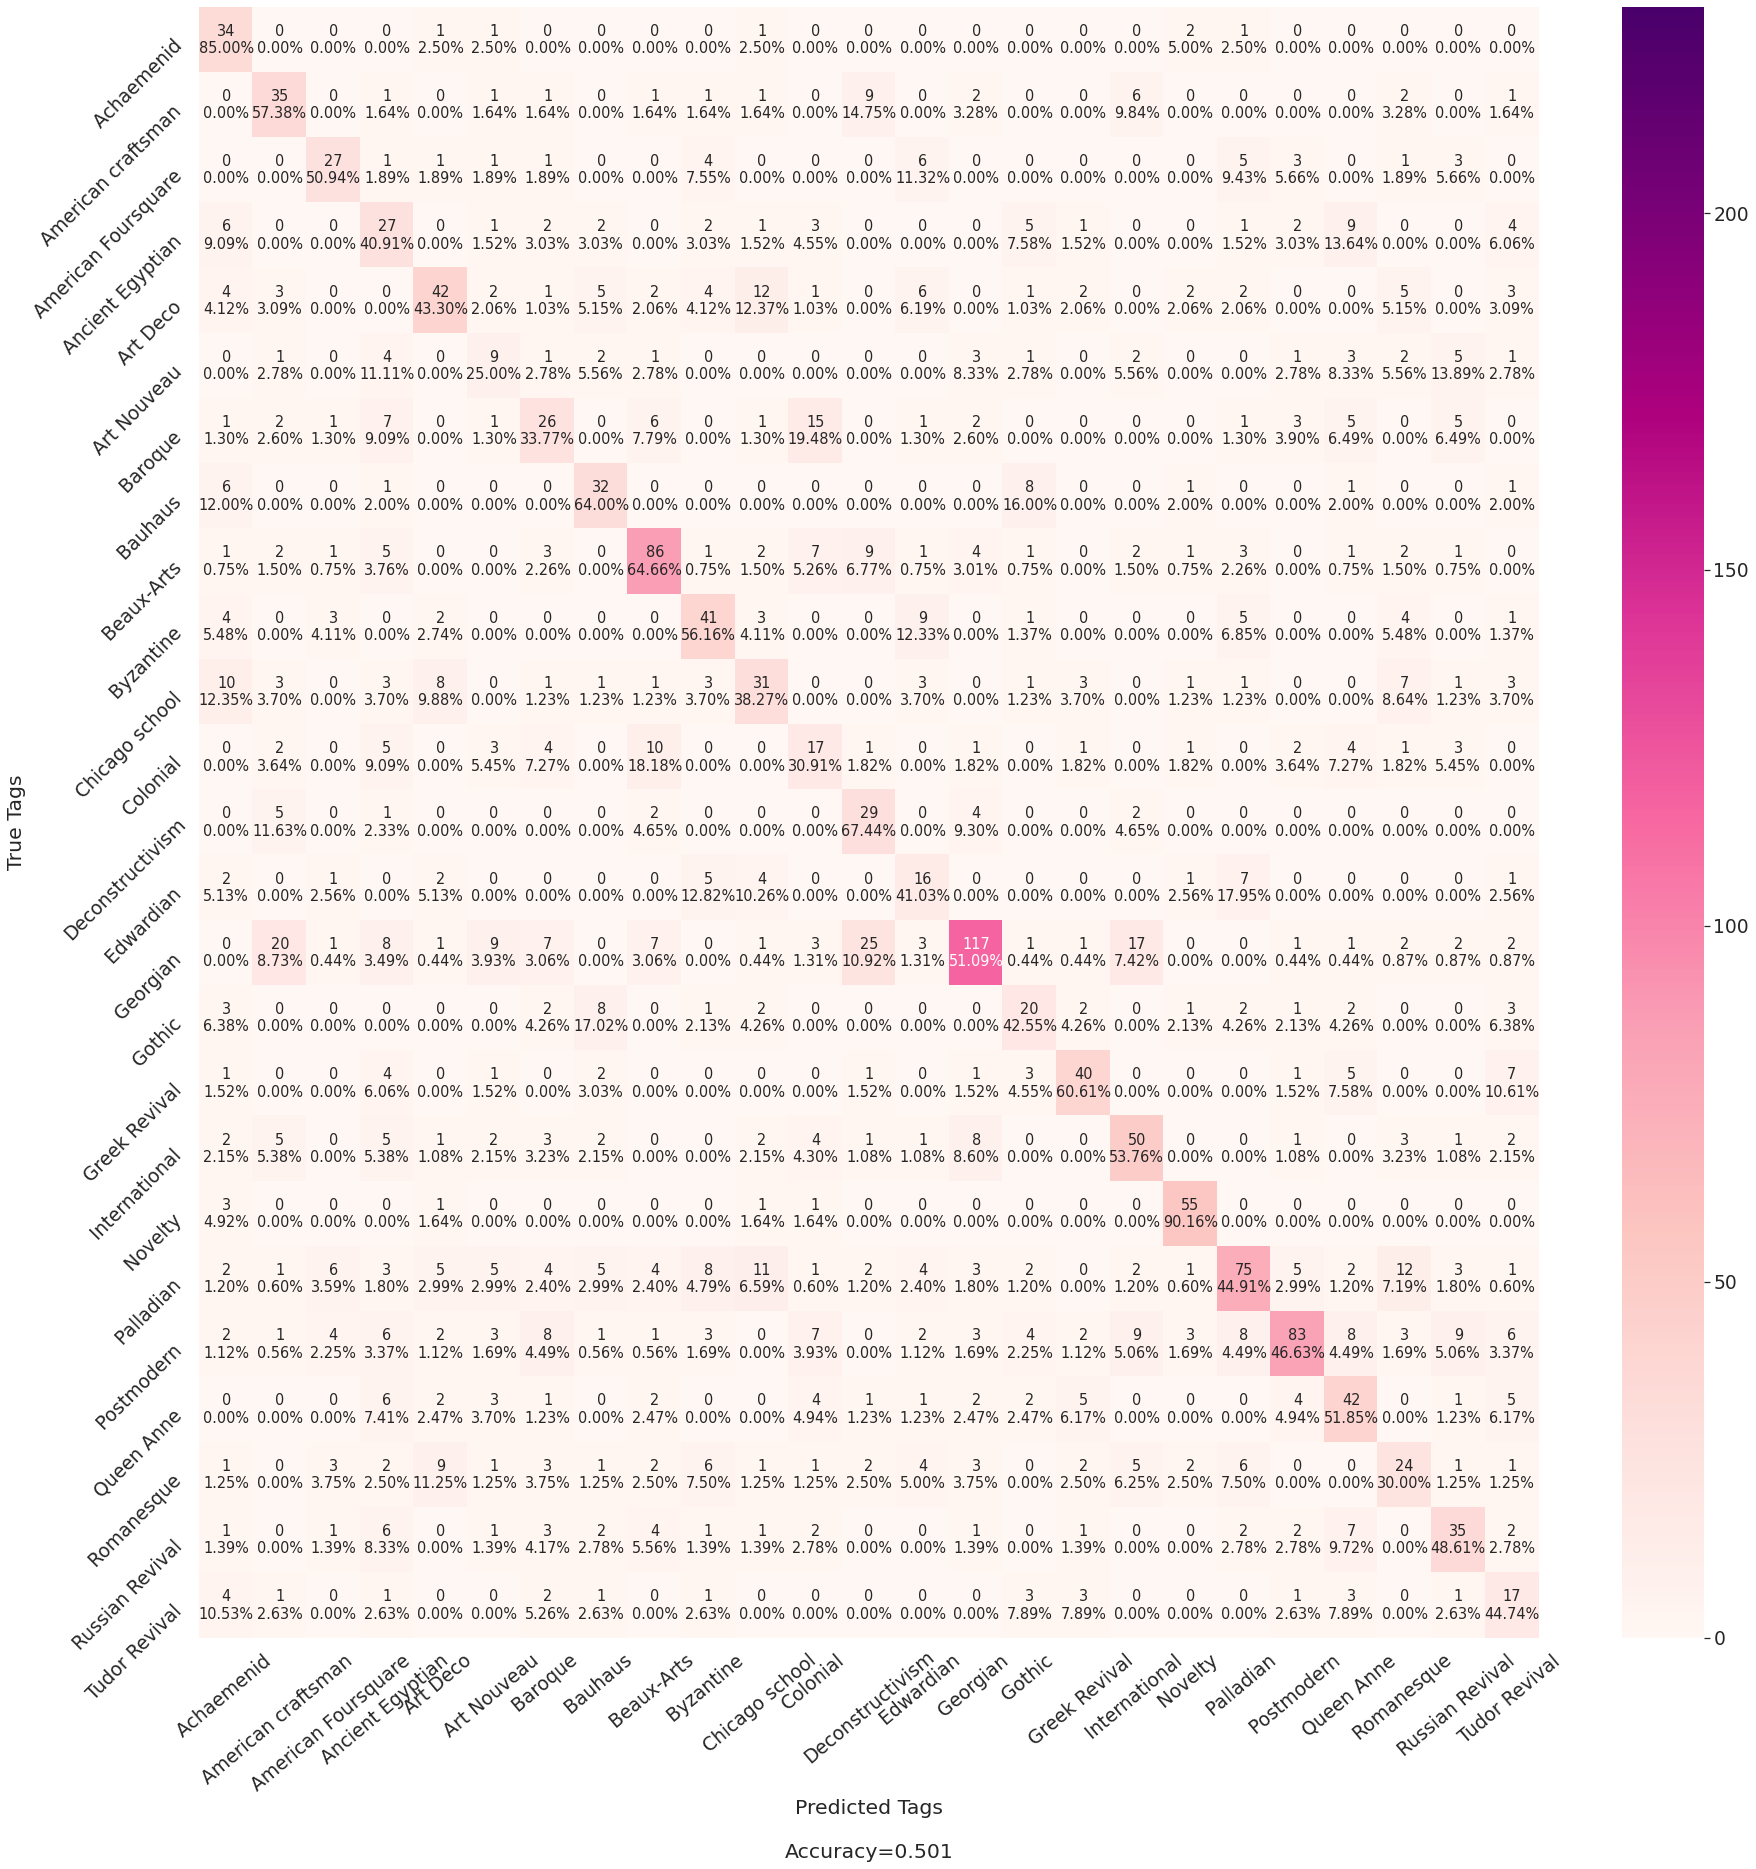

In [ ]:
# PRINT THE CONFUSION MATRIX
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import pandas as pd

#code adapted from https://github.com/DTrimarchi10/confusion_matrix
def make_confusion_matrix(cf,max_value,
                          group_names = None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]


    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        row_sums = np.sum(cf, axis=1).reshape((1,-1))

        #print("CF:\n{}\nRow_sums:\n{}".format(cf, row_sums.reshape((1,-1))) )
        #print("Column division:{}".format(cf/row_sums.reshape((1,-1))  ))

        percentage_grid = np.zeros_like(cf, dtype=np.float) 

        for r in range(percentage_grid.shape[0]):
          percentage_grid[r,:] = cf[r,:]/row_sums[0,r]

        group_percentages = ["{0:.2%}".format(value) for value in percentage_grid.flatten()]
        
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    #compute the upper bound for the colorbar
    #max_value = np.max(np.sum(cf_matrix, axis=1))

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.set(font_scale=1.7)
    sns.heatmap(cf,annot_kws={"size": 14.5}, annot=box_labels,fmt="", cmap=cmap,vmin=0,vmax=max_value,cbar=cbar,xticklabels=categories,yticklabels=categories)
    sns.set(font_scale = 1.0)

    if xyplotlabels:
        plt.ylabel('True Tags')
        plt.xlabel('Predicted Tags' + stats_text)
        plt.xticks(rotation=40)
        plt.yticks(rotation=45)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


# Prove per inserire le classi al posto degli indici
categories = range(0,25) # ho riscalato le classi
categories = ["Achaemenid architecture","American craftsman style","American Foursquare architecture","Ancient Egyptian architecture","Art Deco architecture","Art Nouveau architecture","Baroque architecture","Bauhaus architecture","Beaux-Arts architecture","Byzantine architecture","Chicago school architecture","Colonial architecture","Deconstructivism","Edwardian architecture","Georgian architecture","Gothic architecture","Greek Revival architecture","International style","Novelty architecture","Palladian architecture","Postmodern architecture","Queen Anne architecture","Romanesque architecture","Russian Revival architecture","Tudor Revival architecture"]
categories = [s.replace("architecture", "").replace("style", "") for s in categories]

y_true_l = [""] * len(y_true)
for i in range(len(y_true)):
  y_true_l[i] = categories[int(y_true[i])]

predictions_l = [""] * len(y_true)
for i in range(len(y_true)):
  predictions_l[i] = categories[int(predictions[i])] 

cf_matrix = confusion_matrix(predictions_l, y_true_l, labels = categories)

#fine prove

make_confusion_matrix(cf_matrix, max_value = np.max(np.sum(cf_matrix, axis=1)),
                          group_names = None,
                          categories=categories,
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=[30,30],
                          cmap='RdPu',
                          title=None)  

